In [1]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set(font_scale=1)

import numpy as np
import pandas as pd

from sklearn.datasets import load_boston

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the boston dataset.
boston = load_boston()
X, y = boston['data'], boston['target']

In [3]:
df = pd.DataFrame(data=X, columns=boston.feature_names)

df['target'] = y

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
target     0
dtype: int64

## scaling 

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()

In [7]:
scaledX = scaler.fit_transform(X)

In [8]:
scaled_df = pd.DataFrame(scaledX, columns=boston.feature_names)

In [9]:
scaled_df['target'] = y

In [10]:
scaled_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [11]:
X = scaled_df.drop(['target'], axis=1)
y = scaled_df['target']

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

## Check for multi-collinearity

#### method 1 - pandas corr 

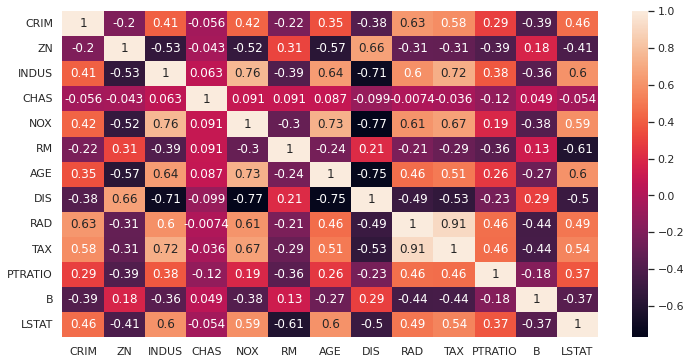

In [14]:
plt.figure(figsize=(12, 6))
sns.heatmap(X.corr(), annot=True);

#### method 2 - VIF 

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [16]:
# check VIF for all columns
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
           index=X.columns)

CRIM       1.792192
ZN         2.298758
INDUS      3.991596
CHAS       1.073995
NOX        4.393720
RM         1.933744
AGE        3.100826
DIS        3.955945
RAD        7.484496
TAX        9.008554
PTRATIO    1.799084
B          1.348521
LSTAT      2.941491
dtype: float64

TYpically VIF >= 20 [15] is considered to be indicative of multi-collinearity

But we dont see that evidence here

#### method 3 - eigen value method

In [17]:
from numpy.linalg import inv

import scipy 
import scipy.linalg as la

np.set_printoptions(precision=4)

In [18]:
# check the multi collinearity
corr = np.corrcoef(X.values, rowvar=False)

eigvals, eigvecs = la.eig(corr)

eigvals = eigvals.real

print(eigvals)
print(eigvecs)

[6.1268 1.4333 1.2426 0.8576 0.8348 0.6574 0.5354 0.3961 0.0635 0.2769
 0.1693 0.186  0.2202]
[[-0.251   0.3153 -0.2466 -0.0618  0.0822  0.2197 -0.7776 -0.1534 -0.046
  -0.2604  0.0868  0.1096 -0.0194]
 [ 0.2563  0.3233 -0.2959 -0.1287  0.3206  0.3234  0.275   0.4027  0.0809
  -0.3581 -0.0714 -0.2628 -0.2675]
 [-0.3467 -0.1125  0.0159 -0.0171 -0.0078  0.0761  0.3396 -0.1739  0.2511
  -0.6444 -0.1132  0.3032  0.3635]
 [-0.005  -0.4548 -0.2898 -0.8159  0.0865 -0.1675 -0.0741  0.0247 -0.0359
   0.0137 -0.004  -0.0139  0.0062]
 [-0.3429 -0.2191 -0.121   0.1282  0.1369  0.153   0.1996 -0.0801 -0.0436
   0.0185  0.8043 -0.1113 -0.2311]
 [ 0.1892 -0.1493 -0.594   0.2806 -0.4234 -0.0593 -0.0639  0.3268 -0.0456
  -0.0479  0.1529 -0.0532  0.4314]
 [-0.3137 -0.312   0.0177  0.1752  0.0167  0.0717 -0.116   0.6008  0.0386
   0.0676 -0.2119  0.4592 -0.3628]
 [ 0.3215  0.3491  0.0497 -0.2154  0.0986 -0.0234  0.1039  0.1218  0.0183
   0.1533  0.3909  0.6957  0.1712]
 [-0.3198  0.2715 -0.2873 -0.1323 -

#### method 4 - statsmodel summary

In [19]:
import statsmodels.api as sm

In [20]:
X.shape, y.shape

((506, 13), (506,))

In [21]:
# adding a constant
X_val = sm.add_constant(X.values) 
y_val = y.values

In [22]:
model = sm.OLS(y, X).fit()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.106
Model:                            OLS   Adj. R-squared (uncentered):              0.082
Method:                 Least Squares   F-statistic:                              4.477
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                    3.14e-07
Time:                        16:29:46   Log-Likelihood:                         -2304.8
No. Observations:                 506   AIC:                                      4636.
Df Residuals:                     493   BIC:                                      4691.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.9281      1.388     -0.669      0.504      -3.654       1.798
ZN             1.0816      1.571      0.688      0.492      -2.006       4.169
INDUS          0.1409      2.071      0.068      0.946      -3.928       4.210
CHAS           0.6817      1.074      0.635      0.526      -1.429       2.792
NOX           -2.0567      2.173     -0.947      0.344      -6.325       2.212
RM             2.6742      1.441      1.855      0.064      -0.158       5.506
AGE            0.0195      1.825      0.011      0.991      -3.567       3.605
DIS           -3.1040      2.062     -1.506      0.133      -7.154       0.946
RAD            2.6622      2.836      0.939      0.348      -2.909       8.234
TAX           -2.0768      3.111     -0.668      0.505      -8.189       4.035
PTRATIO       -2.0606      1.390     -1.482      0.139      -4.792       0.671
B              0.8493      1.204      0.706      0.481      -1.516       3.214
LSTAT         -3.7436      1.778     -2.106      0.036      -7.236      -0.251
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                         9.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## linear regression

In [24]:
from sklearn.linear_model import LinearRegression

from scipy.stats import shapiro
from scipy import stats
from sklearn import metrics

In [25]:
# instantiate
linreg = LinearRegression()

y-intercept             :  22.393640092621784
beta coefficients       :  [-1.0817  1.3413 -0.1125  0.3208 -1.7815  2.4531  0.3231 -3.0938  2.5446
 -2.0564 -1.8194  1.1382 -3.8301]
Mean Abs Error   MAE    :  3.85730090799551
Mean Sq  Error MSE      :  32.44253669600675
Root Mean Sq Error RMSE :  5.695835030617262
r2 value                :  0.6745585065949402
MAPE                    :  17.27885332820333
MPE                     :  -0.7286657155591582

Statistics=0.878, p=0.000
residuals does not look Gaussian, MODEL is NOT valid


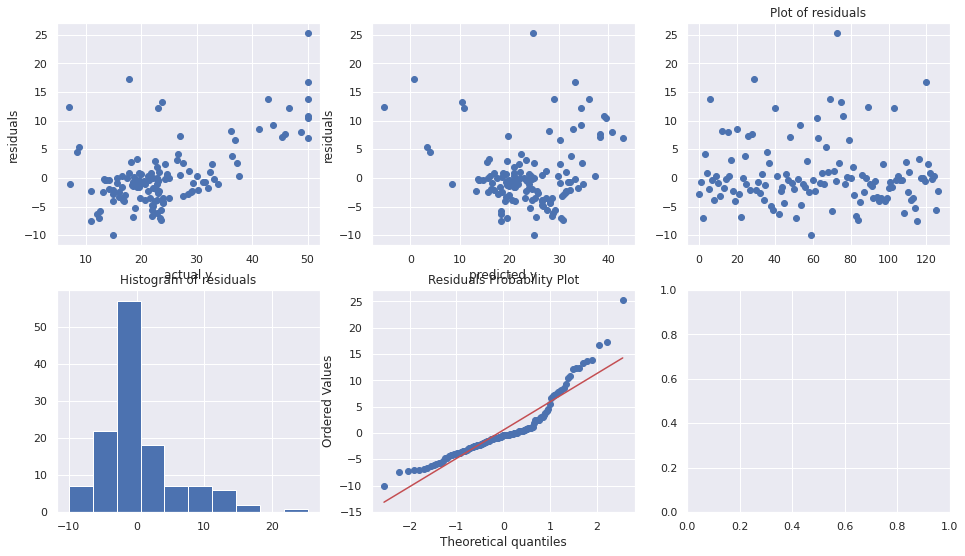

In [26]:
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

residuals = y_test - y_pred

# Model evaluation metrics for regression
print('y-intercept             : ', linreg.intercept_)
print('beta coefficients       : ', linreg.coef_)
print('Mean Abs Error   MAE    : ', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Sq  Error MSE      : ', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Sq Error RMSE : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2 value                : ', metrics.r2_score(y_test, y_pred))
print('MAPE                    : ', np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
print('MPE                     : ', np.mean((y_test - y_pred) / y_test) * 100)

stat, p = shapiro(y_test - y_pred) # null-hypothesis of the test is population is normally distributed
    
print('\nStatistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('residuals look Gaussian, MODEL is valid')
else:
    print('residuals does not look Gaussian, MODEL is NOT valid')
    
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3 , figsize=(16, 9))

ax1.scatter(y_test, residuals)
ax1.set_xlabel('actual y')
ax1.set_ylabel('residuals')

ax2.scatter(y_pred, residuals)
ax2.set_xlabel('predicted y' )
ax2.set_ylabel('residuals' )

# scatter plot of residuals
ax3.scatter(range(len(residuals)), residuals)
ax3.set_title('Plot of residuals')

# histogram plot (residuals)
ax4.hist(residuals)
ax4.set_title('Histogram of residuals')

stats.probplot(residuals, plot= ax5)
ax5.set_title("Residuals Probability Plot");

## is the linear regression overfitting?

In [27]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [28]:
kf = KFold(n_splits=10, shuffle=True, random_state=100)

In [29]:
linreg = LinearRegression()

In [30]:
scoring = ['neg_mean_squared_error', 'r2']

scores = cross_validate(estimator=linreg, 
                        X        =X, 
                        y        =y, 
                        scoring  =scoring, 
                        cv       =kf, 
                        return_train_score=True)

for key in scores:
    print(key, scores[key].mean())

fit_time 0.0024234294891357423
score_time 0.001988077163696289
test_neg_mean_squared_error -23.81768586694798
train_neg_mean_squared_error -21.79658865059044
test_r2 0.7135018842600858
train_r2 0.7418079010922346


In [31]:
scores

{'fit_time': array([0.0028, 0.0023, 0.0022, 0.0024, 0.0025, 0.0023, 0.0023, 0.0029,
        0.0023, 0.0023]),
 'score_time': array([0.0022, 0.0019, 0.002 , 0.0021, 0.0019, 0.002 , 0.002 , 0.0019,
        0.002 , 0.002 ]),
 'test_neg_mean_squared_error': array([-12.9718, -35.1684, -39.2642, -21.1606, -23.8339, -14.1214,
        -14.9839, -25.0313, -25.1593, -26.4821]),
 'train_neg_mean_squared_error': array([-22.9923, -20.5308, -20.0469, -22.0628, -21.7255, -22.8084,
        -22.7313, -21.7426, -21.6987, -21.6266]),
 'test_r2': array([0.8361, 0.6912, 0.6384, 0.6614, 0.7136, 0.8171, 0.7872, 0.6378,
        0.7235, 0.6287]),
 'train_r2': array([0.7295, 0.7467, 0.7546, 0.746 , 0.743 , 0.7319, 0.7353, 0.7438,
        0.7403, 0.7468])}

## Lasso regression

#### determine the ball park range for $\lambda$

In [32]:
np.set_printoptions(suppress=True)

In [33]:
from sklearn.linear_model import Lasso

In [34]:
n_alphas = 200
alphas   = np.logspace(-1, 1, n_alphas)

In [35]:
intercept = []
coefs     = []

train_r_squared = np.zeros(n_alphas)
test_r_squared  = np.zeros(n_alphas)

for ind, a in enumerate(alphas):
    
    lasso_model = Lasso(alpha=a, fit_intercept=True) 
    
    lasso_model.fit(X, y)
    
    coefs.append(lasso_model.coef_)
    intercept.append(lasso_model.intercept_)
    
    train_r_squared[ind] = lasso_model.score(X_train, y_train)
    test_r_squared[ind]  = lasso_model.score(X_test,  y_test)

In [36]:
coefs_arr = np.array(coefs)

In [37]:
col_names = X.columns
col_names

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

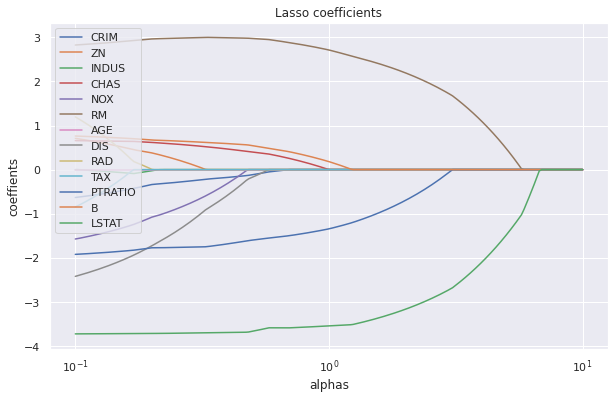

In [38]:
# Display results
plt.figure(figsize=(10, 6))
#plt.grid()
ax = plt.gca()

for col_index in range(len(col_names)):

    ax.plot(alphas, coefs_arr[:, col_index], label = col_names[col_index])
    
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.xlabel('alphas')
plt.ylabel('coeffients')

plt.title('Lasso coefficients')
plt.legend();

#### grid search on $\lambda$

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [40]:
model = Lasso( )

In [41]:
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [42]:
alphas   = np.linspace(0.01, .7, 50)

In [43]:
# define the parameters
parameters = dict(
                alpha= alphas,
                fit_intercept=['True']
            )

print(parameters)

{'alpha': array([0.01  , 0.0241, 0.0382, 0.0522, 0.0663, 0.0804, 0.0945, 0.1086,
       0.1227, 0.1367, 0.1508, 0.1649, 0.179 , 0.1931, 0.2071, 0.2212,
       0.2353, 0.2494, 0.2635, 0.2776, 0.2916, 0.3057, 0.3198, 0.3339,
       0.348 , 0.362 , 0.3761, 0.3902, 0.4043, 0.4184, 0.4324, 0.4465,
       0.4606, 0.4747, 0.4888, 0.5029, 0.5169, 0.531 , 0.5451, 0.5592,
       0.5733, 0.5873, 0.6014, 0.6155, 0.6296, 0.6437, 0.6578, 0.6718,
       0.6859, 0.7   ]), 'fit_intercept': ['True']}


In [44]:
kf = KFold(n_splits=10, shuffle=True, random_state=100)

In [45]:
# instantiate the grid search CV
grid = GridSearchCV(estimator = model, 
                   param_grid = parameters, 
                   scoring    = 'r2',
                   cv=kf,
                   verbose=1)

In [46]:
grid.fit(X, y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': array([0.01  , 0.0241, 0.0382, 0.0522, 0.0663, 0.0804, 0.0945, 0.1086,
       0.1227, 0.1367, 0.1508, 0.1649, 0.179 , 0.1931, 0.2071, 0.2212,
       0.2353, 0.2494, 0.2635, 0.2776, 0.2916, 0.3057, 0.3198, 0.3339,
       0.348 , 0.362 , 0.3761, 0.3902, 0.4043, 0.4184, 0.4324, 0.4465,
       0.4606, 0.4747, 0.4888, 0.5029, 0.5169, 0.531 , 0.5451, 0.5592,
       0.5733, 0.5873, 0.6014, 0.6155, 0.6296, 0.6437, 0.6578, 0.6718,
       0.6859, 0.7   ]),
                         'fit_intercept': ['True']},
             scoring='r2', verbose=1)

In [47]:
print('Estimator: \n',    grid.best_estimator_)
print('Best params : \n', grid.best_params_)
print(grid.best_score_)

Estimator: 
 Lasso(alpha=0.03816326530612245, fit_intercept='True')
Best params : 
 {'alpha': 0.03816326530612245, 'fit_intercept': 'True'}
0.7148801592579614


## setup LASSO model

y-intercept             :  22.390120714816927
beta coefficients       :  [-1.0018  1.2282 -0.1234  0.3123 -1.5818  2.533   0.1721 -2.9194  2.0968
 -1.6971 -1.7643  1.1226 -3.7727]
Mean Abs Error   MAE    :  3.8470184400238923
Mean Sq  Error MSE      :  32.481904739650304
Root Mean Sq Error RMSE :  5.699289845204428
r2 value                :  0.6741635931195901
MAPE                    :  17.221968572880023
MPE                     :  -0.7646790259382938

Statistics=0.872, p=0.000
residuals does not look Gaussian, MODEL is NOT invalid


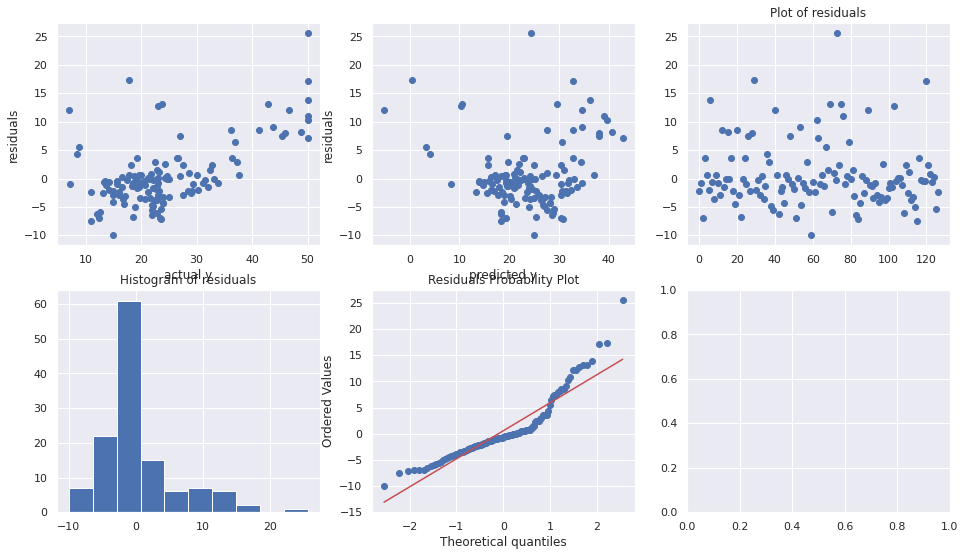

In [48]:
# instantiate
lassoreg = Lasso(alpha=0.031, fit_intercept=True)

lassoreg.fit(X_train, y_train)

y_pred= lassoreg.predict(X_test)

residuals = y_test - y_pred

# Model evaluation metrics for regression
print('y-intercept             : ', lassoreg.intercept_)
print('beta coefficients       : ', lassoreg.coef_)
print('Mean Abs Error   MAE    : ', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Sq  Error MSE      : ', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Sq Error RMSE : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2 value                : ', metrics.r2_score(y_test, y_pred))
print('MAPE                    : ', np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
print('MPE                     : ', np.mean((y_test - y_pred) / y_test) * 100)

stat, p = shapiro(y_test - y_pred) # null-hypothesis of the test is population is normally distributed
    
print('\nStatistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('residuals look Gaussian, MODEL is valid')
else:
    print('residuals does not look Gaussian, MODEL is NOT invalid')
    
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3 , figsize=(16, 9))

ax1.scatter(y_test, residuals)
ax1.set_xlabel('actual y')
ax1.set_ylabel('residuals')

ax2.scatter(y_pred, residuals)
ax2.set_xlabel('predicted y' )
ax2.set_ylabel('residuals' )

# scatter plot of residuals
ax3.scatter(range(len(residuals)), residuals)
ax3.set_title('Plot of residuals')

# histogram plot (residuals)
ax4.hist(residuals)
ax4.set_title('Histogram of residuals')

stats.probplot(residuals, plot= ax5)
ax5.set_title("Residuals Probability Plot");